In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import interpolate

In [ ]:
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder {folder_path} created successfully.")
    else:
        print(f"Folder {folder_path} already exists.")


create_folder_if_not_exists("plots")
create_folder_if_not_exists("errors")

pi = np.double(np.pi)
interval_start = -2 * pi
interval_end = pi
base_domain = np.arange(interval_start, interval_end, 0.00943)


def function_given(x):
    m = 2
    k = 2
    global pi
    return np.sin(m * x) * np.sin(k * (x * x) / pi)


def first_derivative(x):
    m = 2
    k = 2
    global pi
    return 2 * k * x * np.cos(k * x ** 2 / pi) * np.sin(m * x) / pi + m * np.sin(k * x ** 2 / pi) * np.cos(m * x)

**Równomierna dystrybucja**

In [ ]:
def even_domain(x_min, x_max, number_of_points):
    return np.linspace(x_min, x_max, number_of_points, dtype=np.double)

**Zera wielomianu Czebyszewa**

In [ ]:
def get_chebyshev_zeros(x_min=None, x_max=None, number_of_points=None):
    if x_min is None and x_max is not None or x_min is not None and x_max is None:
        raise ValueError("x_min and x_max must be both None or both not None")
    chebyshev_zeroes = np.array(0, dtype=np.double)
    for k in range(number_of_points):
        cur_zero = np.cos((2 * k + 1) * np.pi / (2 * number_of_points))
        if x_min is not None and x_max is not None:
            cur_zero = (x_max - x_min) / 2 * cur_zero + (x_max + x_min) / 2
        chebyshev_zeroes = np.append(chebyshev_zeroes, cur_zero)
    return chebyshev_zeroes[1:]

**Wizualizacja**

In [ ]:
def visualise(domain=None, nodes_x=None, nodes_y=None, f_y=None, Pn_x=None, title=None, x_size=8, y_size=6,
              plot_title=None,
              filename=None):
    '''
    :param domain: array of float64, of x coordinates of points to visualise
    :param nodes_x: array of x coordinates of nodes
    :param nodes_y: array of f(x) for each x in nodes_x
    :param f_y: array of f(x) for each x in domain
    :param Pn_x: array of Pn(x) for each x in domain
    :param title: a string
    :param x_size: size of a figure in x axis
    :param y_size: size of a figure in y axis
    :param plot_title: title of a plot
    :param filename: name of a file to save a figure
    :return: None
    '''
    plt.figure(figsize=(x_size, y_size))
    if nodes_x is not None and nodes_y is not None:
        plt.scatter(nodes_x, nodes_y, label="Węzły", color="green")
    if f_y is not None:
        plt.plot(domain, f_y, label="Zadana funckcja", color="blue")

    if title is not None:
        plt.plot(domain, Pn_x, label=title, color="red")
    if plot_title is not None:
        plt.title(plot_title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    if filename is not None:
        plt.savefig(f"plots/{filename}.png", dpi=300, format='png')
    plt.show()

**Implementacja funkcji do laboratorium**

In [ ]:
function_given_values = []
for random_name in range(len(base_domain)):
    function_given_values.append(function_given(base_domain[random_name]))


def get_function_values(X):
    result = np.zeros(len(X), dtype=np.double)
    for i in range(len(X)):
        result[i] = function_given(X[i])
    return result


def get_abs_error(f1, f2):
    max_error = -1
    if len(f1) != len(f2):
        raise Exception("f1 and f2 must have the same length")
    for i in range(len(f1)):
        max_error = max(max_error, abs(f1[i] - f2[i]))
    return max_error


def get_square_mean_error(f1, f2):
    error_sum = 0
    if len(f1) != len(f2):
        raise Exception("f1 and f2 must have the same length")
    for i in range(len(f1)):
        error_sum += (f1[i] - f2[i]) ** 2
    return np.sqrt(error_sum) / len(f1)

**Aproksymacja średniokwadratowa wielomianami algebraicznymi**

In [34]:
def trigonometric_approximation(function, domain, x_zeroes, poly_degree, input_weights=None):
    def scale_number(num, base_interval=(interval_start, interval_end), resultant_interval=(-pi, pi)):
        a_, b_ = base_interval
        c, d = resultant_interval
        scaled_num = ((num - a_) / (b_ - a_)) * (d - c) + c
        return scaled_num

    x_zeroes_scaled = [scale_number(x) for x in x_zeroes]
    a = []
    b = []
    n = len(x_zeroes_scaled)
    for i in range(n):
        a_i = 0
        b_i = 0
        for j in range(n):
            a_i += function(x_zeroes[j]) * np.cos(i * x_zeroes_scaled[j])
            b_i += function(x_zeroes[j]) * np.sin(i * x_zeroes_scaled[j])
        a.append(2 / n * a_i)
        b.append(2 / n * b_i)

    trigonometric_approximation_result = []
    for x in domain:
        x_scaled = scale_number(x)
        trigonometric_approximation_result.append(a[0] / 2)
        for j in range(1, poly_degree + 1):
            trigonometric_approximation_result[-1] += a[j] * np.cos(j * x_scaled) + b[j] * np.sin(j * x_scaled)
    return trigonometric_approximation_result


def visualise_approximation(number_of_nodes, domain, function, poly_degree, filename=None):
    nodes_x = even_domain(x_min=interval_start, x_max=interval_end, number_of_points=number_of_nodes)
    nodes_y = []
    for i in range(len(nodes_x)):
        nodes_y.append(function(nodes_x[i]))
    approximation_result = trigonometric_approximation(function=function,
                                                       domain=domain,
                                                       x_zeroes=nodes_x,
                                                       poly_degree=poly_degree)
    visualise(domain=base_domain, nodes_x=nodes_x, nodes_y=nodes_y, f_y=function_given_values,
              Pn_x=approximation_result,
              title=f"Funkcja aproksymująca",
              plot_title=f"Aproksymacja średniokwadratowa wielomianami algebraicznymi dla {len(nodes_x)} węzłów i m = {poly_degree}",
              filename=filename)

**Wykonanie ćwiczenia**

In [ ]:
visualise(base_domain, None, None, function_given_values)

In [ ]:
tmp = 7
range_length = interval_start - interval_end
tmp /= range_length
tmp *= 2 * np.pi
tmp += -np.pi - (2 * np.pi * interval_start / range_length)
tmp

10
5
Liczba węzłów:  5  stopień wielomianu:  2


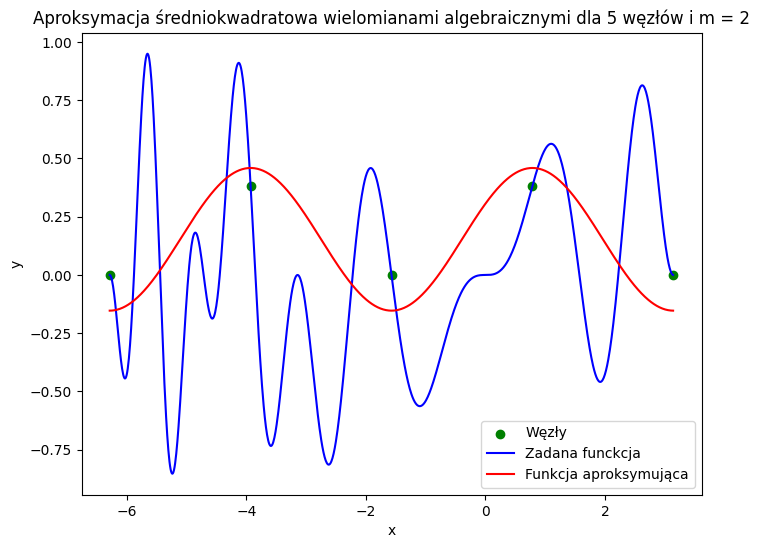

Liczba węzłów:  7  stopień wielomianu:  2


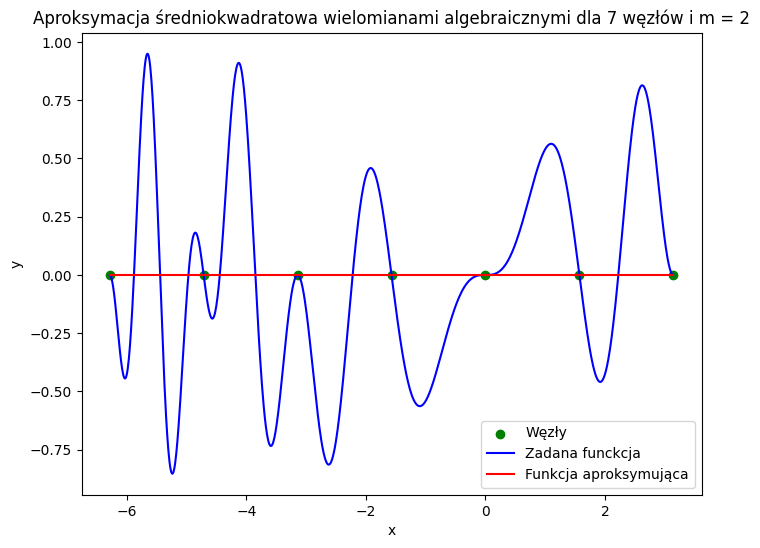

Liczba węzłów:  7  stopień wielomianu:  3


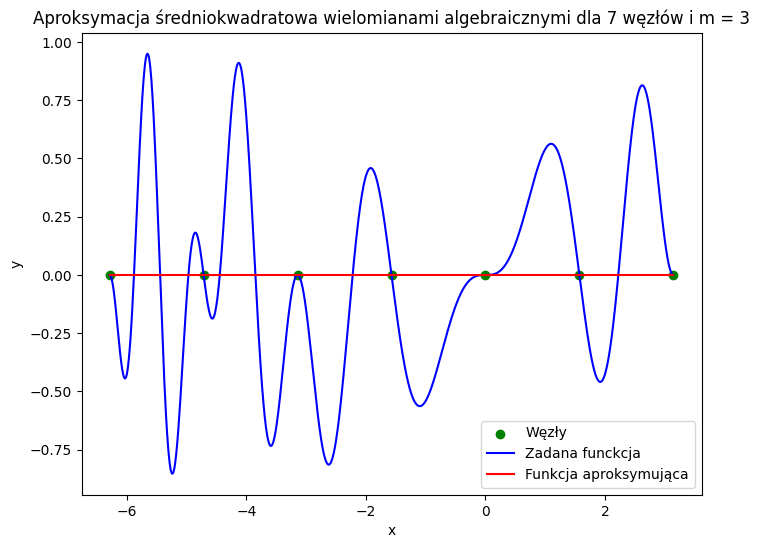

Liczba węzłów:  10  stopień wielomianu:  2


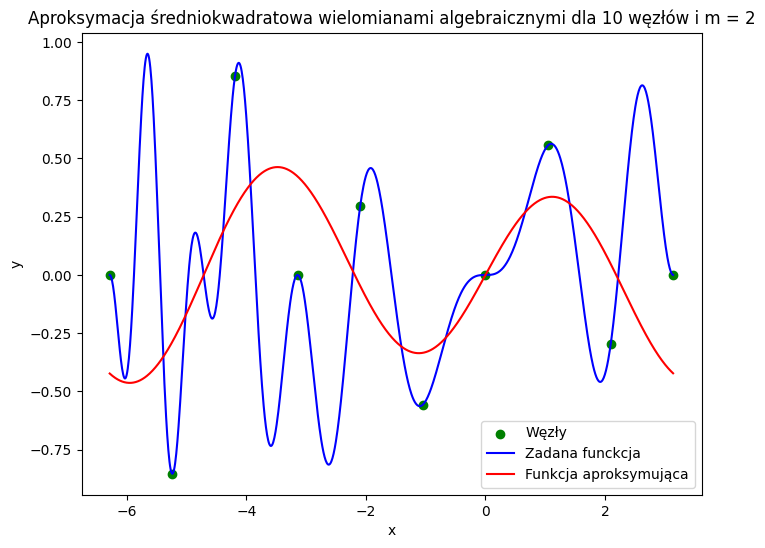

Liczba węzłów:  10  stopień wielomianu:  3


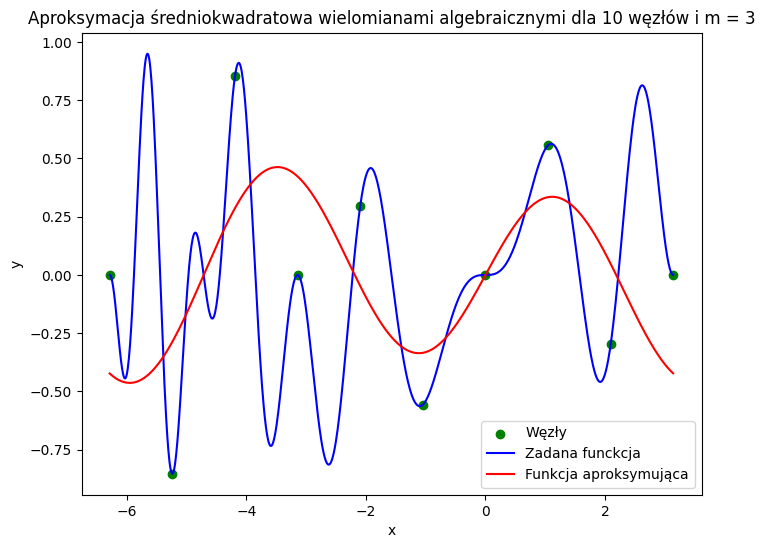

Liczba węzłów:  15  stopień wielomianu:  2


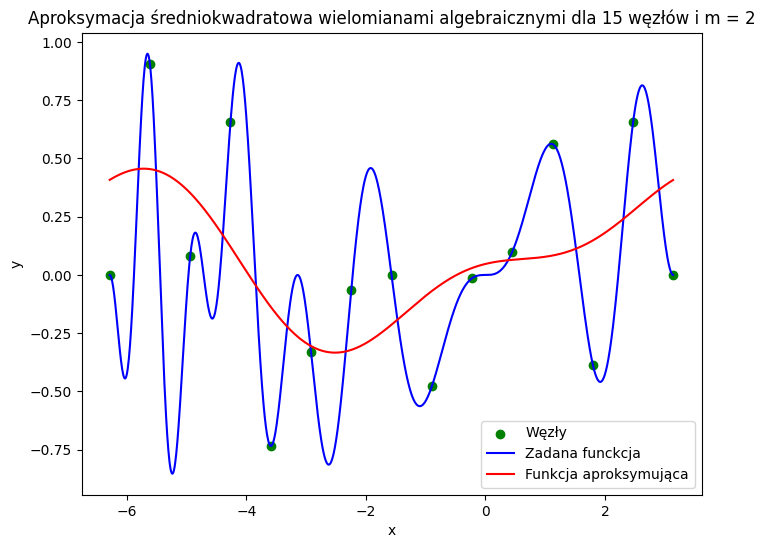

Liczba węzłów:  15  stopień wielomianu:  3


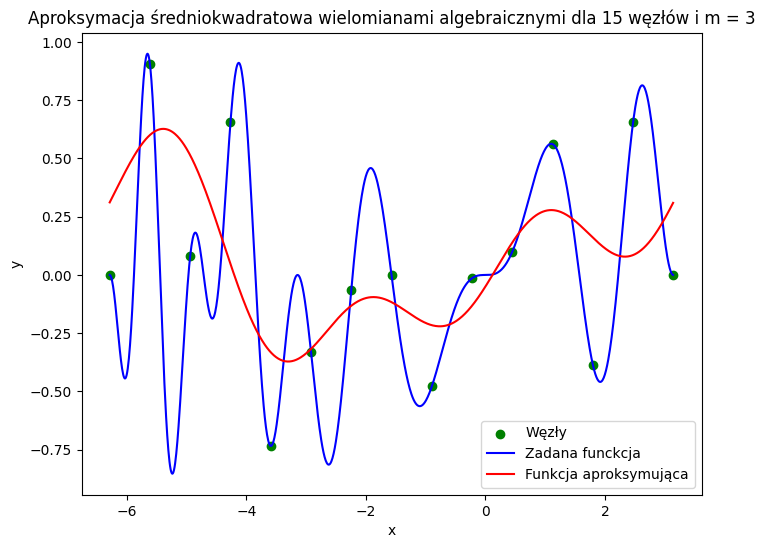

Liczba węzłów:  15  stopień wielomianu:  5


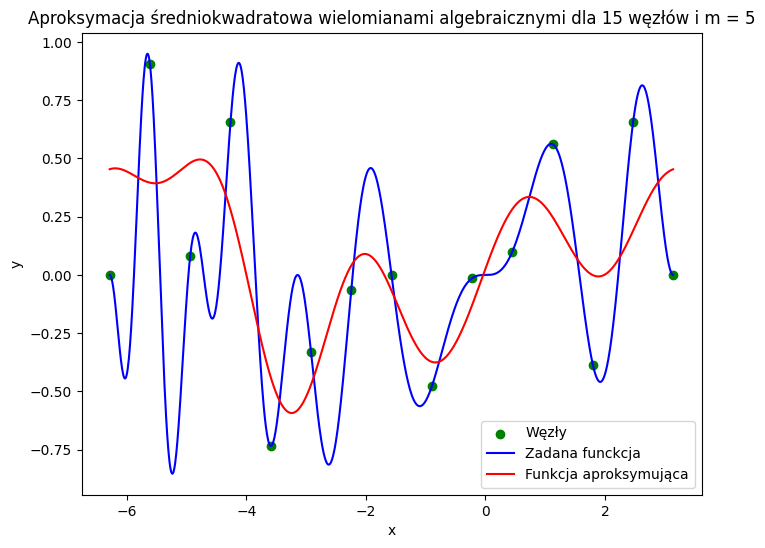

Liczba węzłów:  20  stopień wielomianu:  2


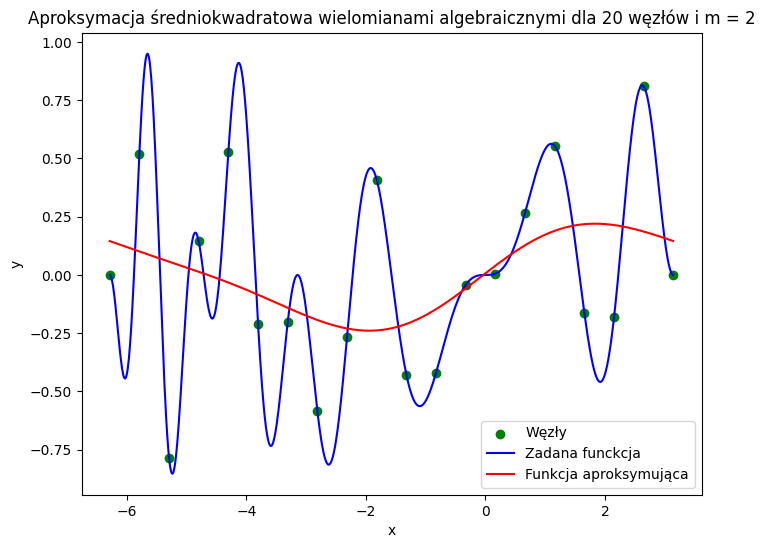

Liczba węzłów:  20  stopień wielomianu:  3


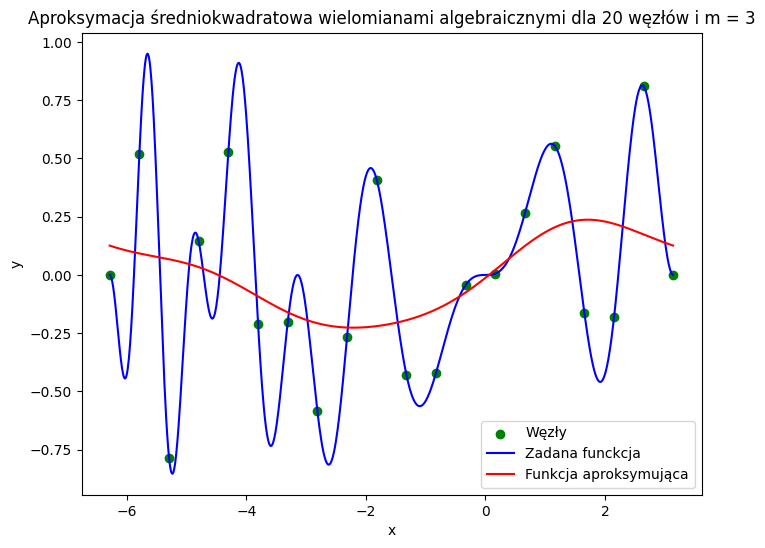

Liczba węzłów:  20  stopień wielomianu:  5


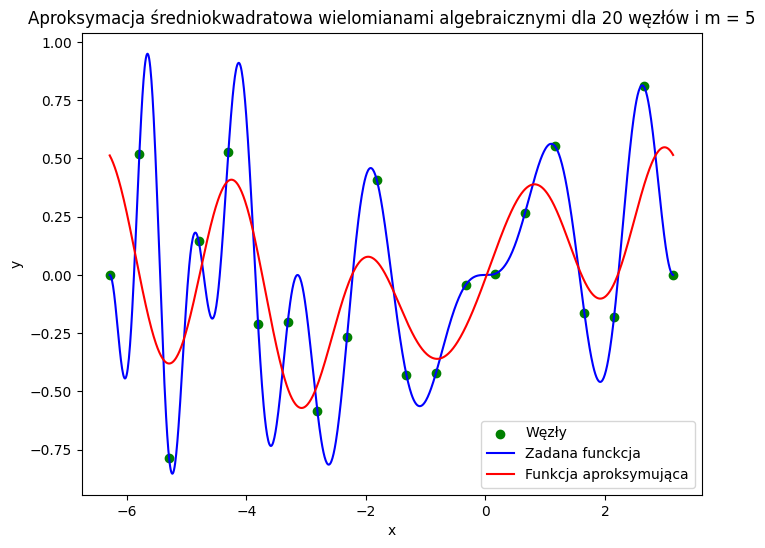

Liczba węzłów:  25  stopień wielomianu:  2


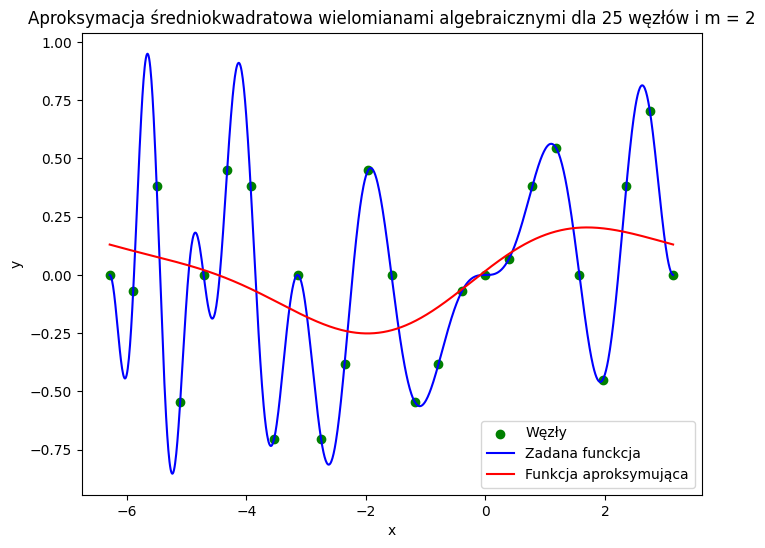

Liczba węzłów:  25  stopień wielomianu:  3


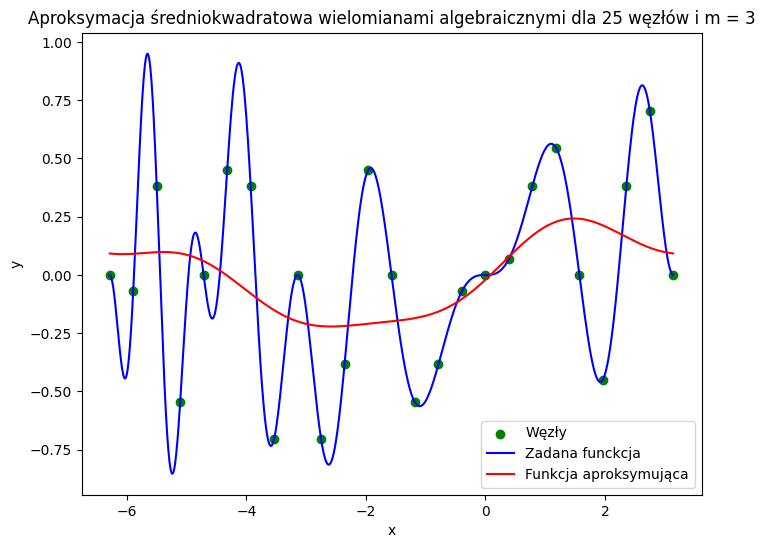

Liczba węzłów:  25  stopień wielomianu:  5


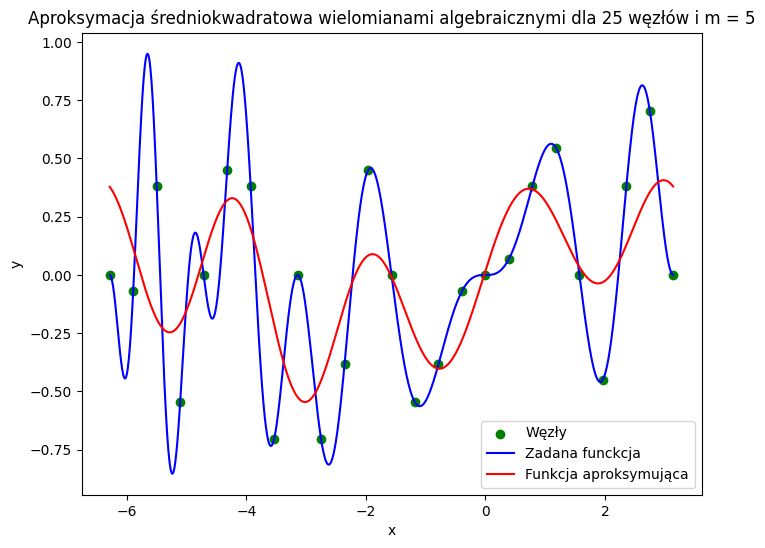

Liczba węzłów:  25  stopień wielomianu:  10


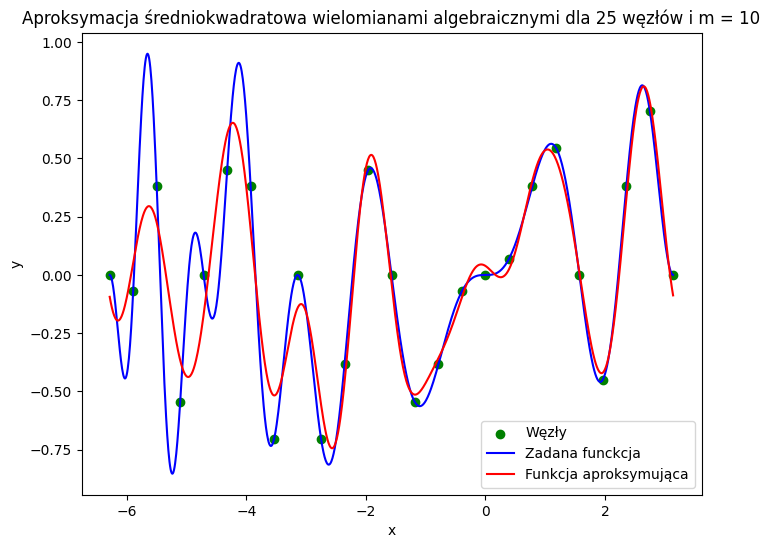

Liczba węzłów:  30  stopień wielomianu:  2


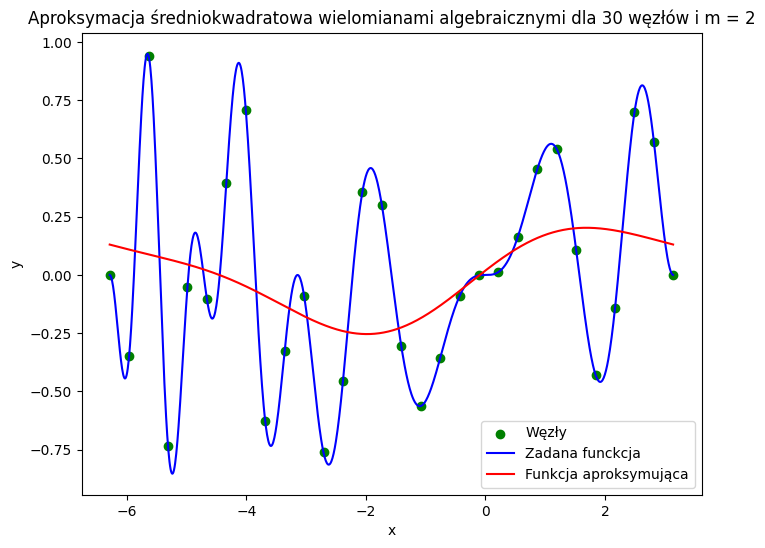

Liczba węzłów:  30  stopień wielomianu:  3


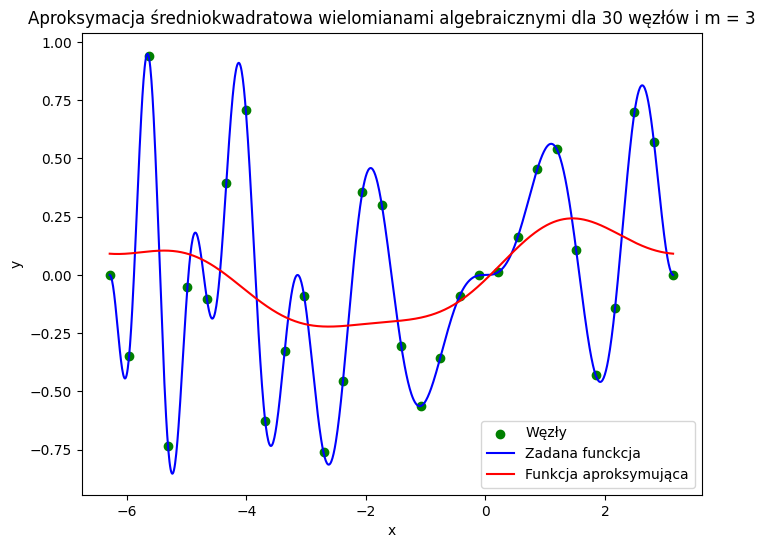

Liczba węzłów:  30  stopień wielomianu:  5


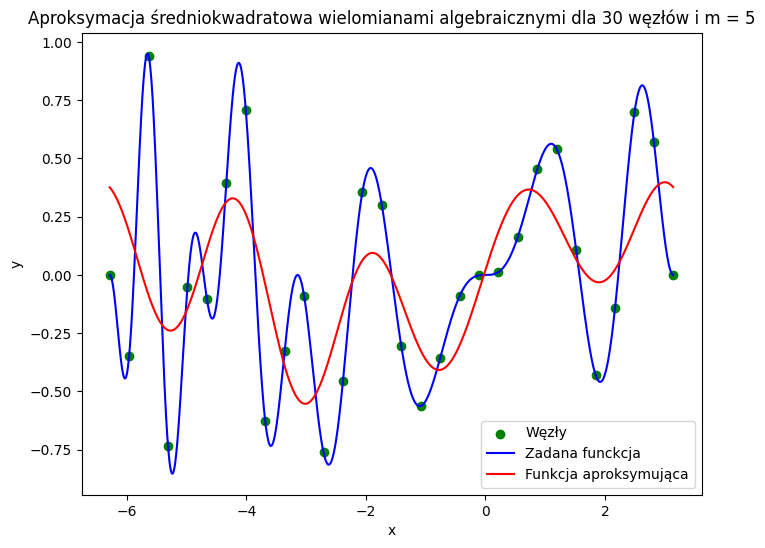

Liczba węzłów:  30  stopień wielomianu:  10


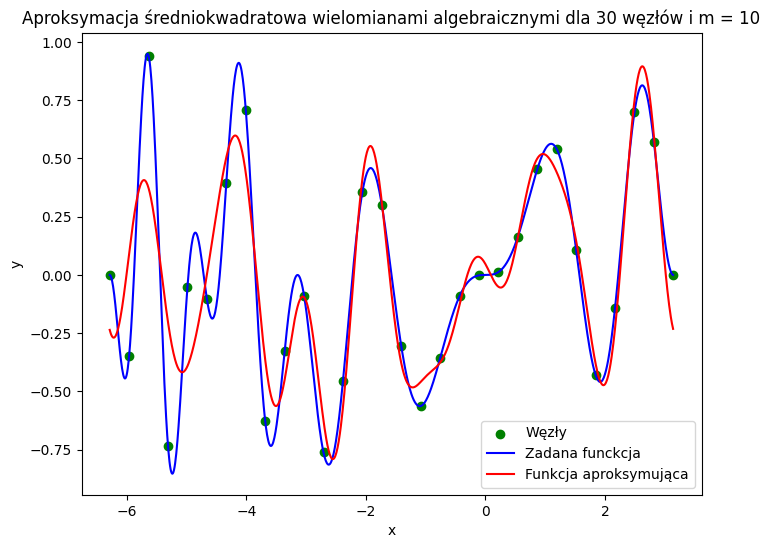

Liczba węzłów:  35  stopień wielomianu:  2


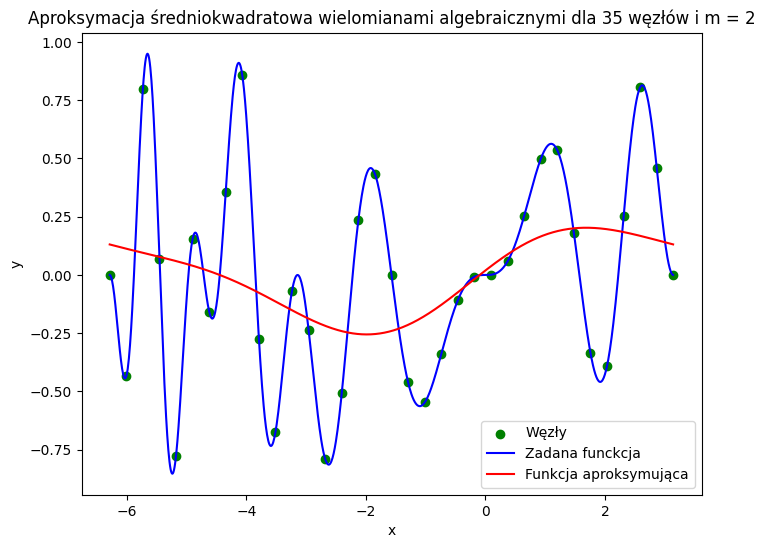

Liczba węzłów:  35  stopień wielomianu:  3


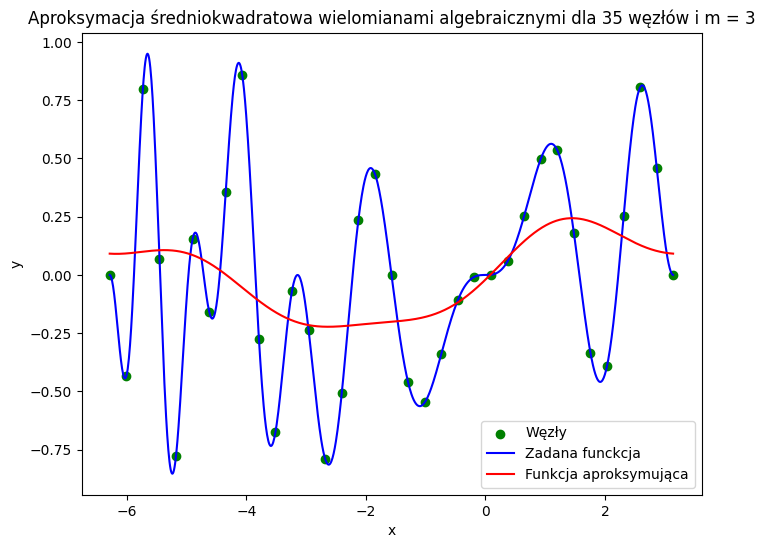

Liczba węzłów:  35  stopień wielomianu:  5


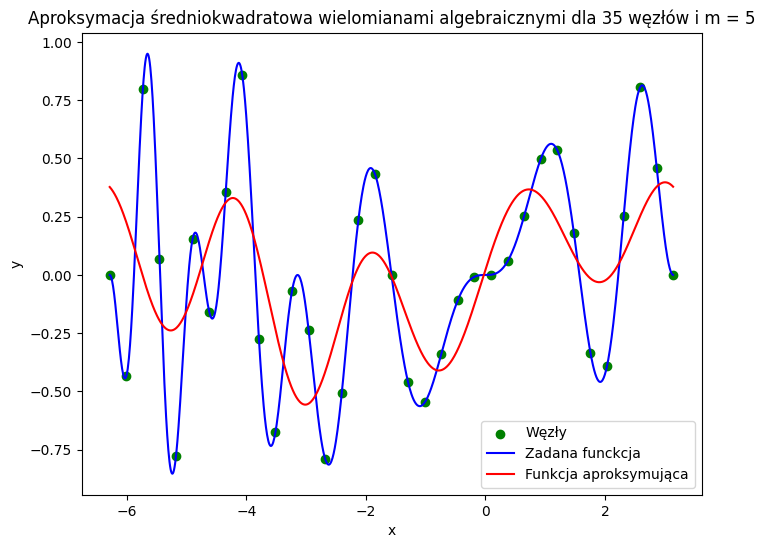

Liczba węzłów:  35  stopień wielomianu:  10


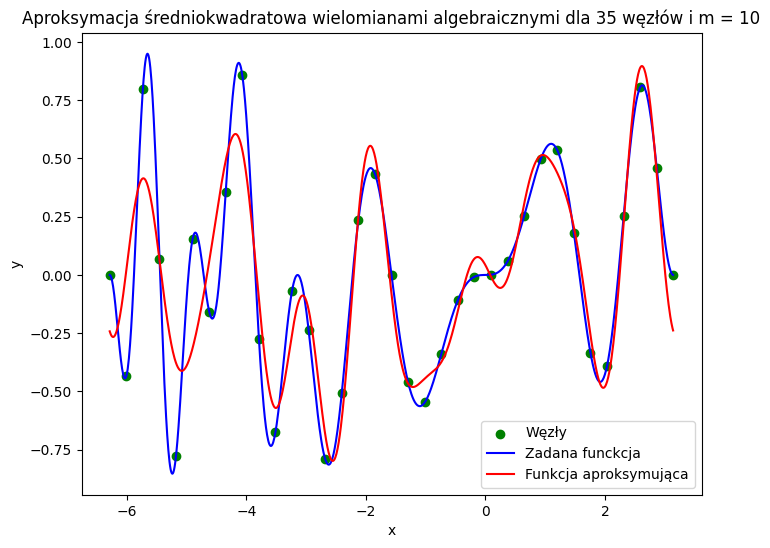

Liczba węzłów:  35  stopień wielomianu:  15


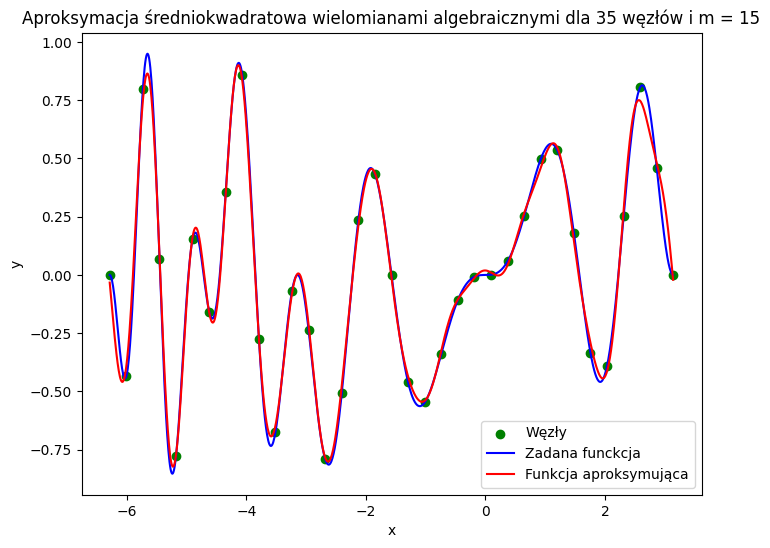

Liczba węzłów:  50  stopień wielomianu:  2


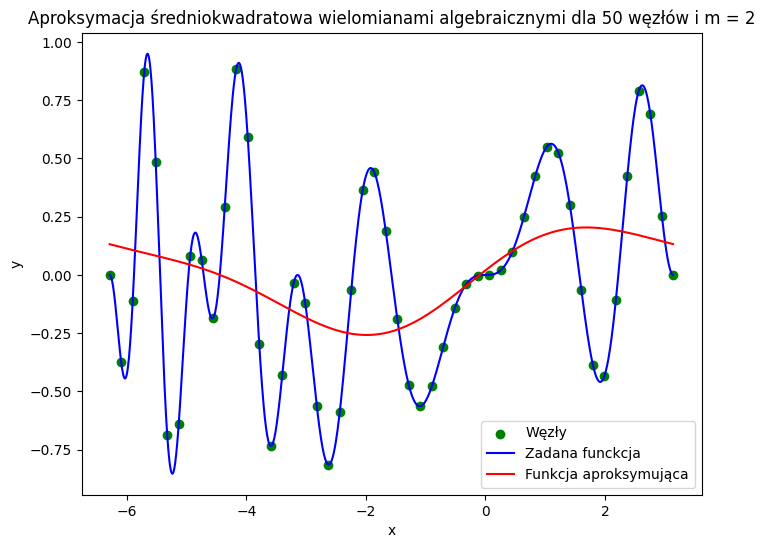

Liczba węzłów:  50  stopień wielomianu:  3


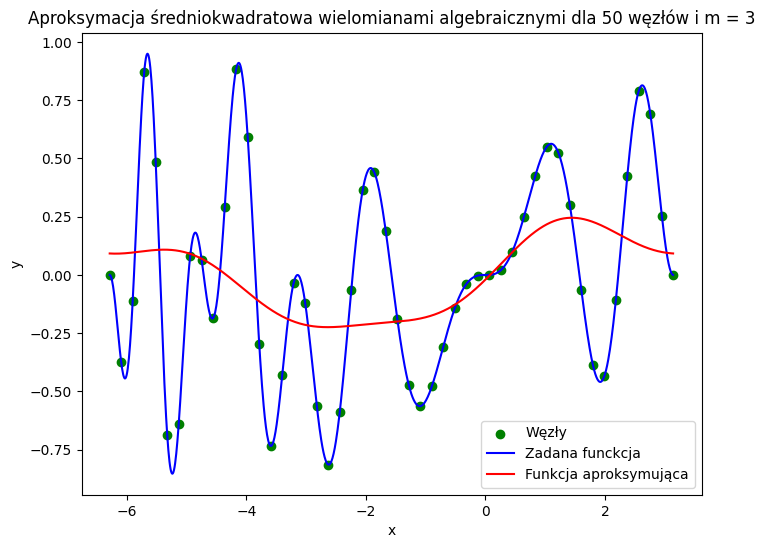

Liczba węzłów:  50  stopień wielomianu:  5


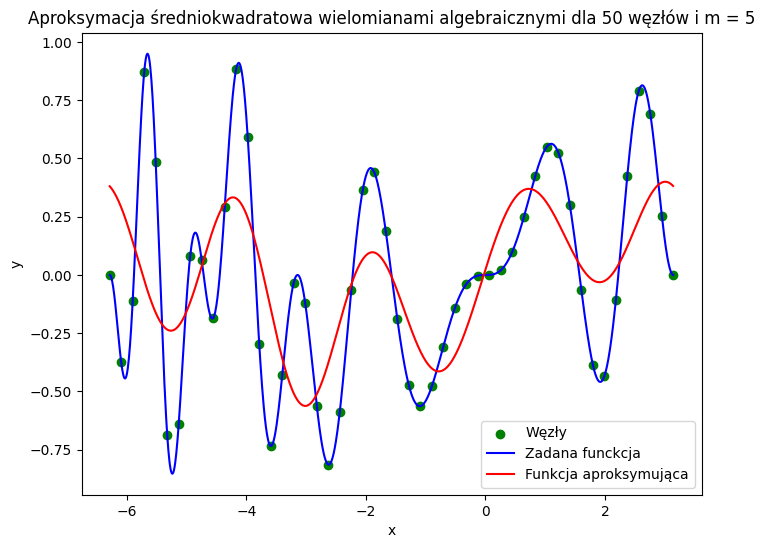

Liczba węzłów:  50  stopień wielomianu:  10


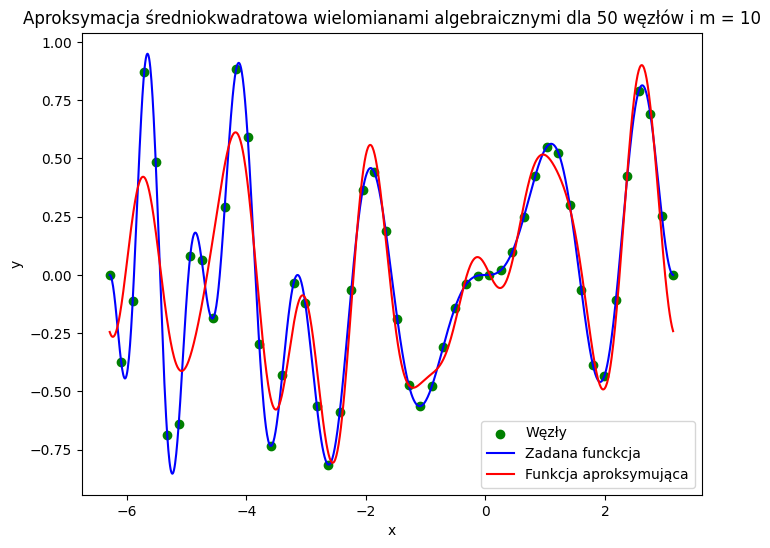

Liczba węzłów:  50  stopień wielomianu:  15


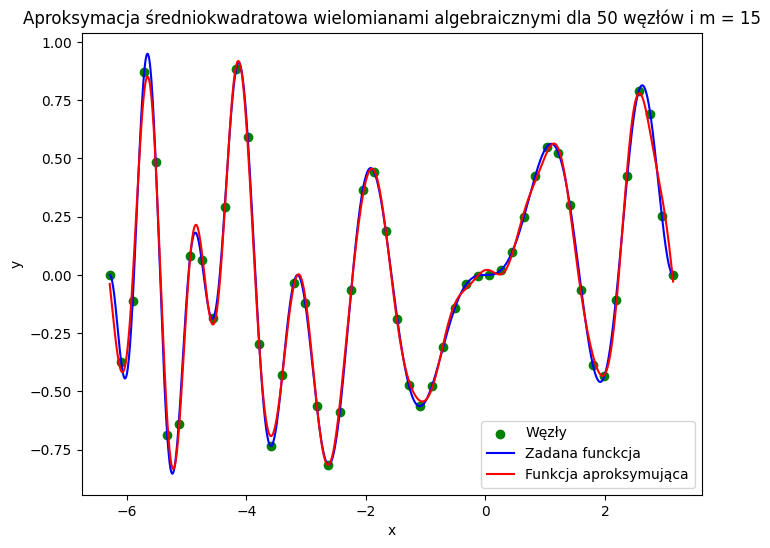

In [38]:
given_number_of_nodes = [3, 5, 7, 10, 15, 20, 25, 30, 35, 50]
given_poly_degree = [2, 3, 5, 10, 15]

print(len(given_number_of_nodes))
print(len(given_poly_degree))


def get_all_visualisations(number, degree):
    if degree > (number - 1) // 2:
        #print("Nie można wyznaczyć wielomianu o stopniu większym niż (n-1)/2")
        return

    print("Liczba węzłów: ", number, " stopień wielomianu: ", degree)
    visualise_approximation(number_of_nodes=number,
                            domain=base_domain,
                            function=function_given,
                            poly_degree=degree,
                            filename=f"n_{number}_m_{degree}")


for number in given_number_of_nodes:
    for degree in given_poly_degree:
        get_all_visualisations(number, degree)

In [ ]:
import csv


def save_to_csv(filename, data):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)

In [ ]:
def approximation_results_errors():
    global given_number_of_nodes
    csv_header = ["n", "m", "błąd maksymalny", "błąd kwadratowy"]
    csv_file = [csv_header]
    for number_of_nodes in given_number_of_nodes:
        for cur_degree in given_poly_degree:
            csv_record = [number_of_nodes, cur_degree]
            even_nodes = even_domain(x_min=interval_start, x_max=interval_end, number_of_points=number_of_nodes)
            exact_result = function_given_values

            poly_approximation_result = trigonometric_approximation(function=function_given,
                                                                    domain=base_domain,
                                                                    x_zeroes=even_nodes,
                                                                    poly_degree=cur_degree)
            poly_approximation_abs_error = get_abs_error(exact_result, poly_approximation_result)
            csv_record.append(poly_approximation_abs_error)
            poly_approximation_result_sqrt_error = get_square_mean_error(exact_result, poly_approximation_result)
            csv_record.append(poly_approximation_result_sqrt_error)
            csv_file.append(csv_record)
        save_to_csv("errors/poly_approx_errors.csv", csv_file)


approximation_results_errors()